# SOEN-6111 Project, Team#28

- Shreyans Sharma - 40196896
- Shubham Sharma - 40198289
- Shubhang Khattar - 40163063
- Bhavitha Yarlagadda - 40180618

**Introduction**

In this project we will create ML classification models using decision tree and K-nearest neighbors approach.
Models can ***predict the activity*** done by the subjects based on the motion sensor data

Data set used : MotionSense Dataset : Smartphone Sensor Data - HAR (https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset)

**About Dataset**

24 subjects (male and female) were asked to do 6 different activities in 15 trials in total. The motion sensor data was collected with an iPhone 6s in a 50Hz sample rate, which means 50 samples per second. The six activities done were the following, along with their abbreviation used in this dataset:

- dws: downstairs
- ups: upstairs
- sit: sitting
- std: standing
- wlk: walking
- jog: jogging

Of the 15 trials, the first 9 were "long" trials, while the trials 11-16 were the "short" version of their respective activity. Trial-ID 10 was left out. The trials in order were the following:

- 1: dws
- 2: dws
- 3: ups
- 4: ups
- 5: sit
- 6: std
- 7: wlk
- 8: wlk
- 9: jog
- 11: dws
- 12: ups
- 13: sit
- 14: std
- 15: wlk
- 16: jog

===========================================

Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from  sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, f1_score
from sklearn_evaluation import plot

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

path = 'archive/A_DeviceMotion_data/A_DeviceMotion_data/'

## Data Loading and Processing

### Data Loading

In [2]:
# Extracting list of directories

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

# Iterating through the extracted directories and appending each csv to dataframes for each subject in each of the trials.

for i in list_of_directories:
    list_of_csv = os.listdir(i)
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[-1].split('_')[0]
        k['trial'] = int(i.split('/')[-1].split('_')[1])
        
        # Deriving features from the given motion sensor data.
        
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)
        
# Creating final dataset dataframe from the list of all individual dataframes.
df = pd.concat(list_of_dfs).set_index('time')

# Dropping unnecessary columns and renaming the ones for rotation.
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

### Analyzing the dataset

In [3]:
print(f"""Total records in the dataset : {df.shape[0]}""")
df.sample(10)

Total records in the dataset : 1412865


,accel_x,accel_y,accel_z,accel_norm,gyro_x,gyro_y,gyro_z,subject,activity,trial
time,,,,,,,,,,
7371,0.596939,0.391235,-0.712189,1.008273,0.004913,-0.005510,0.003274,10,sit,5
3175,0.291138,0.560593,-0.112381,0.641604,-3.289810,2.318890,0.307438,4,wlk,7
1197,0.596054,1.191620,-0.040986,1.333011,-0.264810,0.408850,-0.926414,22,ups,4
6953,-0.531769,0.457794,0.695358,0.987865,-0.073625,-0.065653,-0.026789,19,sit,5
4285,-0.092300,0.969849,0.263488,1.009234,0.010709,0.041893,0.025759,11,std,6
1950,-0.302750,0.288177,0.059158,0.422141,-2.562414,1.717415,-0.363266,1,wlk,7
725,0.458496,0.900833,0.083420,1.014237,0.037304,0.049855,-0.019740,1,std,14
6719,1.734894,1.517792,-0.000488,2.305114,-1.023710,3.185883,0.038943,2,wlk,7
2543,0.267242,1.059692,-0.047821,1.093916,-0.106265,1.200063,-0.028920,8,ups,3


### Class Distribution

Below is the distribution of various classes in the dataset


wlk    344288
sit    338778
std    306427
ups    157285
jog    134231
dws    131856
Name: activity, dtype: int64

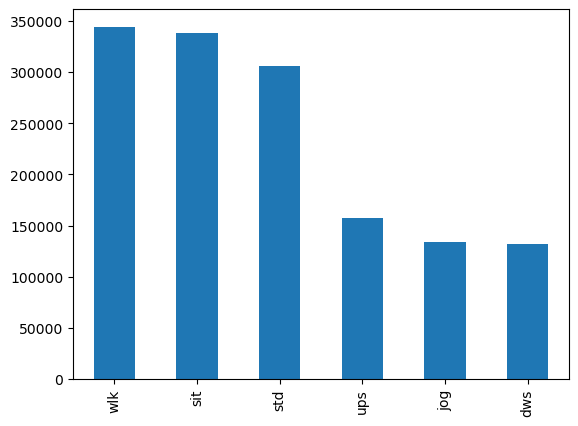

In [4]:
act = df["activity"].value_counts()
print("""Below is the distribution of various classes in the dataset""")
ax = act.plot(kind='bar')
act

# Model Training and Evaluation

## Preparing Data Set

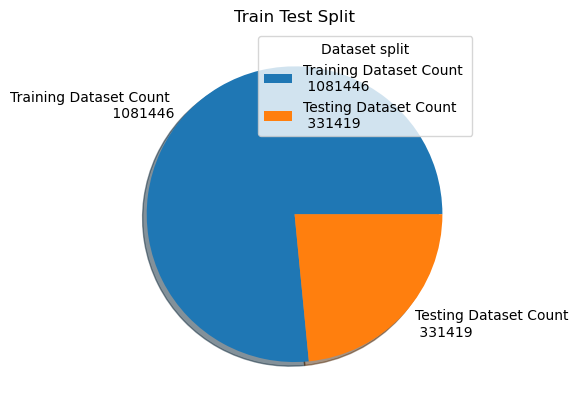

In [5]:
# Separating the dataset into a training set and a test set. 
# Making the cut between the long (1-9) as Training Dataset and the short trials (11-16) as Testing Dataset, 
# This ensures the evenly distribution of classes among training and testing data

train_long_df = df[(df.trial < 10)]
test_short_df = df[(df.trial > 10)]

# Extracting Features and Label for Training and Testing data.

X_train_long = train_long_df.iloc[:,:-3]
y_train_long = train_long_df.activity

X_test_short = test_short_df.iloc[:,:-3]
y_test_short = test_short_df.activity

plt.pie([len(train_long_df), len(test_short_df)], labels = [f"Training Dataset Count \n {len(train_long_df)}",f"Testing Dataset Count \n {len(test_short_df)}"], shadow = True)
plt.legend(title = "Dataset split")
plt.title('Train Test Split')
plt.show() 

## Decision Tree

***Model Creation and Training***

***Finding Maximum Optimal Depth Using Elbow Method***

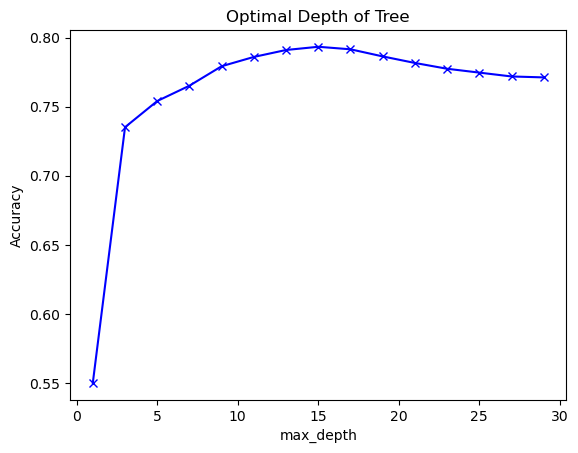

In [6]:
max_depth = range(1, 30, 2)

# List to store accuracy for each depth range
accuracy_dtc = []
for depth in max_depth:
    
    dtc = DecisionTreeClassifier(criterion="entropy",max_depth = depth, 
                             random_state = 0)
    dtc.fit(X_train_long, y_train_long)
    score = dtc.score(X_test_short, y_test_short)
    accuracy_dtc.append(score)

# Plotting max_depth vs Accuracy.
plt.plot(max_depth,accuracy_dtc,"bx-")
plt.xlabel("max_depth") 
plt.ylabel("Accuracy") 
plt.title("Optimal Depth of Tree")
plt.show()

***Opitmal Depth for the model is around 15, Will Tune other hyperparameters as well using Grid Search CV***

### Hyper Parameter Tuning Decision Tree Using Grid Search CV

Using Grid Search CV to find most optimal hyperparameters

In [7]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [14, 15, 16],
              'criterion' :['gini', 'entropy']
             }
dtc_grid = DecisionTreeClassifier(random_state=0)
grid_dtc_model = GridSearchCV(estimator=dtc_grid, param_grid=param_grid, cv=10, verbose=True)
grid_dtc_model.fit(X_train_long, y_train_long)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [14, 15, 16],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=True)

In [8]:
dtc = grid_dtc_model.best_estimator_
dtc

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=16,
                       max_features='auto', random_state=0)

In [9]:
# Training the model.
dtc.fit(X_train_long, y_train_long)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=16,
                       max_features='auto', random_state=0)

### Decision Tree Evaluation

***Classification Report & Confusion Matrix***

In [10]:
# Prediciting labels for testing data
y_pred = dtc.predict(X_test_short)

              precision    recall  f1-score   support

         dws       0.33      0.01      0.02     22502
         jog       0.57      0.42      0.48     29904
         sit       0.98      0.95      0.96    104121
         std       0.92      0.97      0.94     81611
         ups       0.37      0.18      0.24     28009
         wlk       0.49      0.83      0.62     65272

    accuracy                           0.75    331419
   macro avg       0.61      0.56      0.55    331419
weighted avg       0.74      0.75      0.72    331419



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

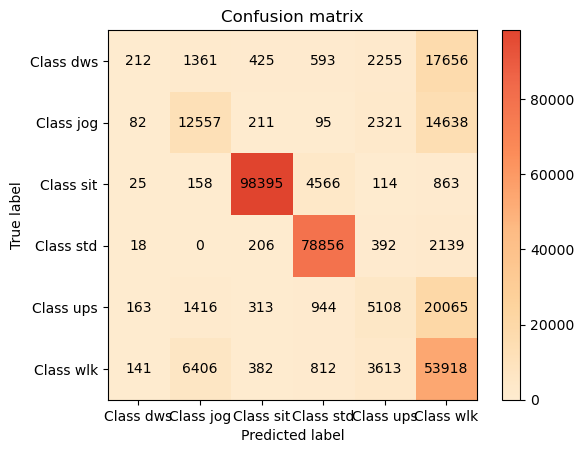

In [13]:
# Evaluating the performance of the model
print(classification_report(y_test_short, y_pred))
plot.confusion_matrix(y_test_short, y_pred)

### K-Fold Decision Tree
Traing and evaluate using K-Fold

In [14]:
X = df.iloc[:,:-3]
y = df["activity"] 

k = 10
kf = KFold(n_splits=k, random_state=None)
model = DecisionTreeClassifier(criterion="entropy", max_depth = 15,random_state=0,)
k_fold_iter = 1
data = {}
acc_score = []
for train_index , test_index in kf.split(X):

    
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    print(f"""Accuracy for K-Fold {k_fold_iter} of {k} : {acc}""")
    data["Fold "+str(k_fold_iter)] = acc
    
    k_fold_iter += 1
    

    
avg_acc_score = sum(acc_score)/k

print("="*30)
print('Avg accuracy : {}'.format(avg_acc_score))

Accuracy for K-Fold 1 of 10 : 0.5887307395584873
Accuracy for K-Fold 2 of 10 : 0.7910777353896679
Accuracy for K-Fold 3 of 10 : 0.6256343471090758
Accuracy for K-Fold 4 of 10 : 0.570236469031121
Accuracy for K-Fold 5 of 10 : 0.7406838562641999
Accuracy for K-Fold 6 of 10 : 0.23785088402247923
Accuracy for K-Fold 7 of 10 : 0.518423623005818
Accuracy for K-Fold 8 of 10 : 0.8535806803221834
Accuracy for K-Fold 9 of 10 : 0.9771031807822431
Accuracy for K-Fold 10 of 10 : 0.97991308409892
Avg accuracy : 0.6883234599584196


***Visualise K-Fold***

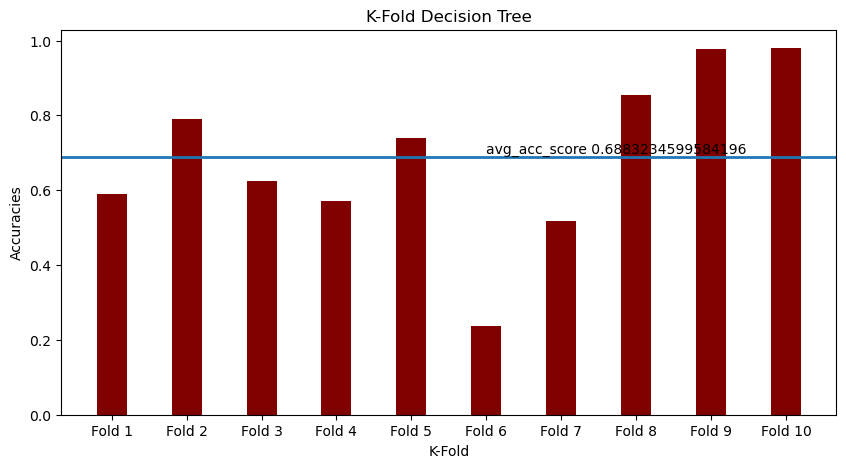

In [15]:
# ax.axvline(data1.mean(), color='blue', linewidth=2)

fold_list = list(data.keys())
accuracy_list = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(fold_list, accuracy_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("K-Fold")
plt.ylabel("Accuracies")
plt.title("K-Fold Decision Tree")
plt.axhline(y=avg_acc_score , linewidth=2)
h_line = "avg_acc_score " + str(avg_acc_score)
plt.text(5, avg_acc_score+0.01,h_line)
plt.show()

## K-Nearest Neighbors

***Model Creation and Training***

***Find best K-Value (Elbow Method)***

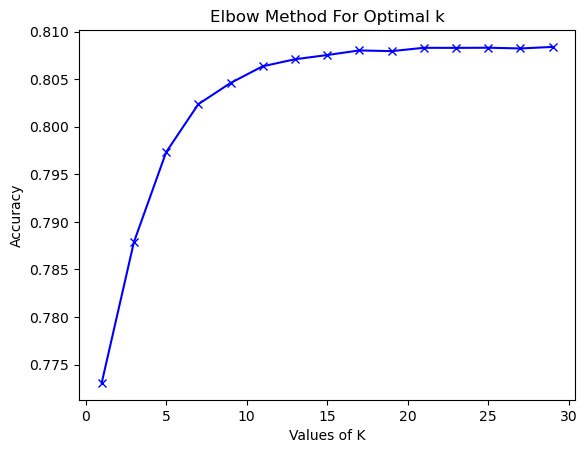

In [16]:
# List to store accuracy for each K range
    
accuracy_knn = []
K = range(1, 30, 2)
for num_clusters in K :
    knn = KNeighborsClassifier(n_neighbors=num_clusters)
    knn.fit(X_train_long,y_train_long)
    score = knn.score(X_test_short, y_test_short)
    accuracy_knn.append(score)

# Plotting K vs Accuracy.
plt.plot(K,accuracy_knn,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Accuracy") 
plt.title("Elbow Method For Optimal k")
plt.show()

***Opitmal K for KNN model is around 15***

### Hyperparameter Tuning KNN using Grid Search CV

In [17]:
# k_range = list(range(1, 31))
# weight_options = ['uniform', 'distance']
# param_grid = dict(n_neighbors=k_range, weights=weight_options)

param_grid_knn = {'n_neighbors': [13,15,17],
              'weights': ['uniform', 'distance'],
             }

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=10, verbose=True)
grid_search.fit(X_train_long, y_train_long)

knn = GridSearchCV(estimator = knn, param_grid = param_grid_knn, cv=10, scoring='accuracy', return_train_score=False)
knn.fit(X, y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [13, 15, 17],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [18]:
knn.best_estimator_

KNeighborsClassifier(n_neighbors=17, weights='distance')

### KNN Evaluation

***Classification Report & Confusion Matrix***

In [19]:
# Prediciting labels for testing data
y_pred = knn.predict(X_test_short)

              precision    recall  f1-score   support

         dws       1.00      1.00      1.00     22502
         jog       1.00      1.00      1.00     29904
         sit       1.00      1.00      1.00    104121
         std       1.00      1.00      1.00     81611
         ups       1.00      1.00      1.00     28009
         wlk       1.00      1.00      1.00     65272

    accuracy                           1.00    331419
   macro avg       1.00      1.00      1.00    331419
weighted avg       1.00      1.00      1.00    331419



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

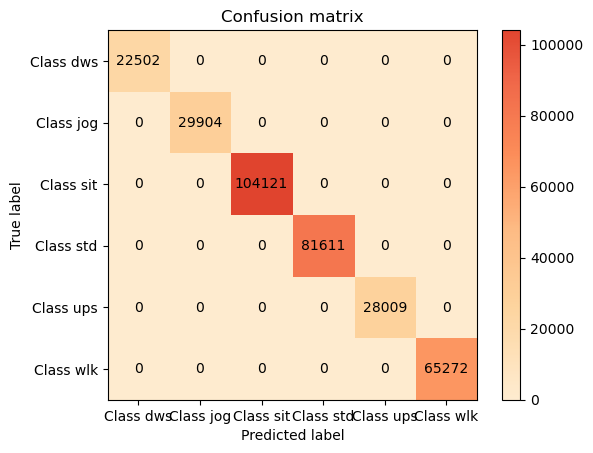

In [22]:
print(classification_report(y_test_short, y_pred))
plot.confusion_matrix(y_test_short, y_pred)

### K-Fold K-Nearest Neighbors

Traing and evaluate using K-Fold

In [23]:
X = df.iloc[:,:-3]
y = df["activity"] 

k = 10
kf = KFold(n_splits=k, random_state=None)
model = KNeighborsClassifier(n_neighbors=15)
k_fold_iter = 1
data = {}
acc_score = []
for train_index , test_index in kf.split(X):

    
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    print(f"""Accuracy for K-Fold {k_fold_iter} of {k} : {acc}""")
    data["Fold "+str(k_fold_iter)] = acc
    
    k_fold_iter += 1
    

    
avg_acc_score = sum(acc_score)/k

print("="*30)
print('Avg accuracy : {}'.format(avg_acc_score))

Accuracy for K-Fold 1 of 10 : 0.642104369121009
Accuracy for K-Fold 2 of 10 : 0.8242867355099903
Accuracy for K-Fold 3 of 10 : 0.6855690898667252
Accuracy for K-Fold 4 of 10 : 0.6218477283826538
Accuracy for K-Fold 5 of 10 : 0.7149419267165416
Accuracy for K-Fold 6 of 10 : 0.30053933156859136
Accuracy for K-Fold 7 of 10 : 0.5757612219186614
Accuracy for K-Fold 8 of 10 : 0.9324349192418215
Accuracy for K-Fold 9 of 10 : 0.9865662556799683
Accuracy for K-Fold 10 of 10 : 0.9852426992058662
Avg accuracy : 0.7269294277211829


***Visualise K-Fold***

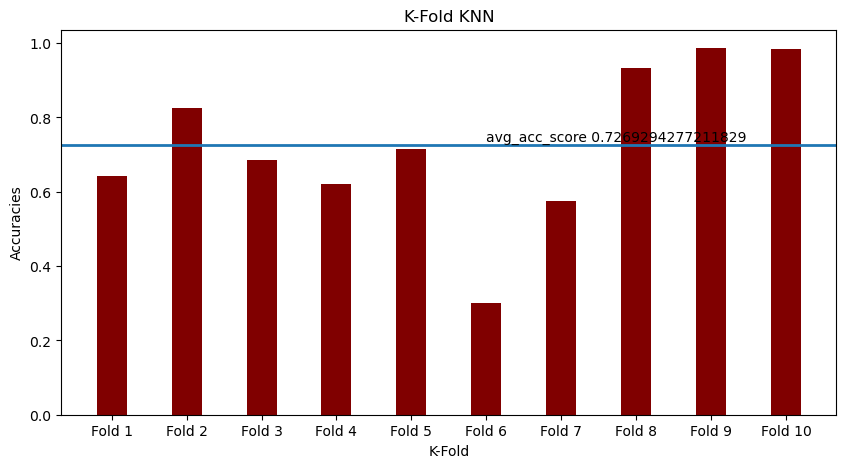

In [24]:
# ax.axvline(data1.mean(), color='blue', linewidth=2)

fold_list = list(data.keys())
accuracy_list = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(fold_list, accuracy_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("K-Fold")
plt.ylabel("Accuracies")
plt.title("K-Fold KNN")
plt.axhline(y=avg_acc_score , linewidth=2)
h_line = "avg_acc_score " + str(avg_acc_score)
plt.text(5, avg_acc_score+0.01,h_line)
plt.show()